In [1]:
from torch import nn
import torch

In [2]:
### CLEANING UP THE DATASET BY REMOVING RETINAL FUNDUS IMAGES FEATURING DISEASES
import os
import pandas as pd
import tqdm

damaged_images = []

print("Scanning through the labels file...")
labels = pd.read_excel("ODIR/labels.xlsx")
for i in tqdm.tqdm(range(len(labels["ID"]))):
    if "normal fundus" not in labels["Left-Diagnostic Keywords"][i]:
        damaged_images.append(labels["Left-Fundus"][i])
    if "normal fundus" not in labels["Right-Diagnostic Keywords"][i]:
        damaged_images.append(labels["Right-Fundus"][i])

print(f"\nLength of the corrected dataset: {len(labels['ID']+1)*2 - len(damaged_images)}")

print(f"\nDeleting the corrupted images...")
dir = os.listdir("ODIR/images")
i = 0
for file in tqdm.tqdm(dir):
    if file in damaged_images:
        os.remove(f"ODIR/images/{file}")


Scanning through the labels file...


100%|██████████| 3500/3500 [00:00<00:00, 80265.86it/s]



Length of the corrected dataset: 3098

Deleting the corrupted images...


100%|██████████| 3100/3100 [00:00<00:00, 26517.91it/s]


In [3]:
### RENAMING FILES TO FEATURE LABEL
dir = os.listdir("ODIR/images/")

for file in tqdm.tqdm(dir):
    matched_rows = labels[(labels["Left-Fundus"] == file) | (labels["Right-Fundus"] == file)]
    if not matched_rows.empty:
        for index, row in matched_rows.iterrows():
            sex = row["Patient Sex"]
            os.rename(file, f'{sex}_{file}')

100%|██████████| 3100/3100 [00:02<00:00, 1204.26it/s]


In [4]:
# IMPORTING DATALOADER
from odir_dataset import ODIRDataset, train_transforms, test_transforms, train_dataset, test_dataset

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
train_data = ODIRDataset(targ_dir=train_dataset,
                         transform=train_transforms)
test_data = ODIRDataset(targ_dir=test_dataset,
                        transform=test_transforms)

In [6]:
from typing import List
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset

#1. Create a function to take in a dataset
def display_random_images(dataset: Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  #2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, n shouldn't be larger than 10, setting it to 10 and removing shape display")

  #3. Set the seed
  if seed:
    random.seed(seed)

  #4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  #5. Setup plot
  plt.figure(figsize=(16, 8))

  #6. Loop through and plot random indexes
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    #7. Adjust tensor dimensions
    targ_image_adjust = targ_image.permute(1, 2, 0)

    #8. Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

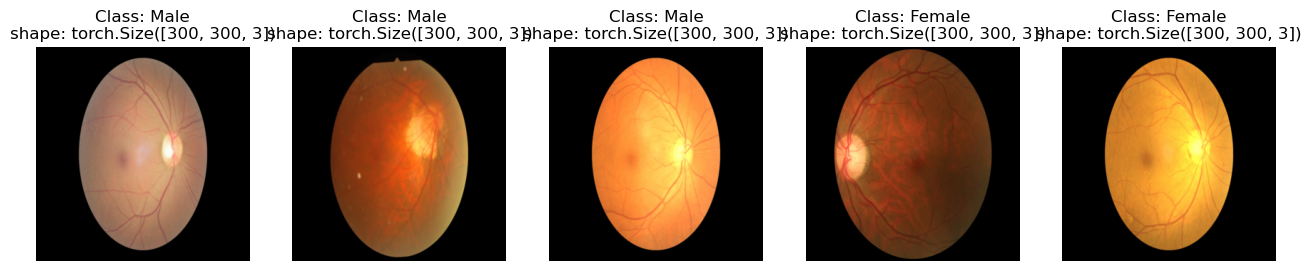

In [7]:
display_random_images(train_data,
                      classes=train_data.classes,
                      n=5)

In [8]:
## LOADING DATA INTO BATCHES
BATCH_SIZE = 32
# NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader  = DataLoader(dataset=test_data,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [9]:
os.path.abspath(os.getcwd())

'/home/u_481835/Neuro140FP/ODIR/images'

In [10]:
train_data

In [10]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader))
img_custom.shape, label_custom.shape

KeyboardInterrupt: 

In [ ]:
### IMPORTING RESNET50
from torchvision.models import resnet50, ResNet50_Weights
model1 = resnet50(weights=ResNet50_Weights.DEFAULT)

In [ ]:
## AGNOSTIC CODE
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
model1.to(device)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

In [ ]:
## DEFININING THE TESTING AND TRAINING
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    print(batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc * 100:.2f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc * 100:.2f}%")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


In [ ]:
# RUNNING THE MODEL
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

optimizer = torch.optim.Adam(params=model1.parameters(),
                            lr=0.01)
loss_fn = nn.CrossEntropyLoss()

from timeit import default_timer as timer

In [ ]:
start_time = timer()
model1_results = train(model=model1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
stop_time = timer()
print(f"Total training time: {stop_time-start_time:.3f} seconds.")

In [17]:
!git config --global user.name "kamiljkon"

In [18]:
!git commit -m "update"

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../../ODIRmodel.ipynb
	modified:   ../../odir_dataset.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../../.ipynb_checkpoints/
	../../__pycache__/odir_dataset.cpython-311.pyc

no changes added to commit (use "git add" and/or "git commit -a")


Username for 'https://github.com': 